In [1]:
from env1 import CustomEnvironment
from tf_agents.environments import py_environment, tf_py_environment
import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory


In [2]:
# # Створення екземпляру середовища
# env = CustomEnvironment(image_path='./img/output1small.png')
# tf_env = tf_py_environment.TFPyEnvironment(env)

# Створення середовища
train_env = tf_py_environment.TFPyEnvironment(CustomEnvironment(image_path='./img/output1small.png'))
eval_env = tf_py_environment.TFPyEnvironment(CustomEnvironment(image_path='./img/output1small.png'))



c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_agents\specs\array_spec.py:352: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_agents\specs\array_spec.py:353: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_agents\specs\array_spec.py:355: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_agents\specs\array_spec.py:356: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high


In [3]:

# Створення Q-мережі
fc_layer_params = (8, 8)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

# Оптимізатор та агент DQN
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Політика та драйвер
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000000)

# метрики
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_steps=1)

In [4]:
# Створення набору даних з буфера відтворення
dataset = replay_buffer.as_dataset(
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    sample_batch_size=train_env.batch_size,
    num_steps=2).prefetch(tf.data.experimental.AUTOTUNE)

# Створення ітератора
iterator = iter(dataset)

# Функція для тренування
def train_agent(num_iterations):
    for i in range(num_iterations):
        # Збір досвіду      
        collect_driver.run()        

        # Оновлення параметрів агента
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience).loss

        step = agent.train_step_counter.numpy()
        if step % 10 == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [5]:
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Збір початкового досвіду для буфера відтворення
initial_collect_steps = 1000  # Кількість кроків для збору початкового досвіду
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

for _ in range(initial_collect_steps):
    time_step = train_env.current_time_step()
    action_step = random_policy.action(time_step)
    next_time_step = train_env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    replay_buffer.add_batch(traj)

In [7]:
# Тренування агента
num_iterations = 150 
print(num_iterations)
train_agent(num_iterations)

150
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 10: loss = 99996000.0
step = 20: loss = 0.0
step = 30: loss = 0.0
step = 40: loss = 0.0
step = 50: loss = 0.0
step = 60: loss = 0.0
step = 70: loss = 0.0
step = 80: loss = 0.14597225189208984
step = 90: loss = 0.0
step = 100: loss = 0.0
step = 110: loss = 0.0
step = 120: loss = 0.0
step = 130: loss = 110.09278106689453
step = 140: loss = 185.50502014160156
step = 150: loss = 0.0


In [8]:
import numpy as np

# Ініціалізація для збору даних
num_episodes = 1  # Кількість епізодів для збору даних
agent_positions = []  # Список для зберігання позицій агента

for i in range(num_episodes):
    print(i)
    time_step = eval_env.reset()
    episode_positions = []

    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)

        # Збереження поточної позиції агента
        # Припускаємо, що позиція агента знаходиться в time_step.observation
        current_position = np.array(time_step.observation.numpy()[0], dtype=np.float32)
        #print(current_position)
        episode_positions.append(current_position)

    agent_positions.append(episode_positions)

# Тепер в agent_positions зберігаються траєкторії для кожного епізоду
agent_positions

0


[[array([0.1    , 0.00193], dtype=float32),
  array([0.1    , 0.00386], dtype=float32),
  array([0.1    , 0.00579], dtype=float32),
  array([0.1    , 0.00772], dtype=float32),
  array([0.1    , 0.00965], dtype=float32),
  array([0.1    , 0.01158], dtype=float32),
  array([0.1    , 0.01351], dtype=float32),
  array([0.1    , 0.01544], dtype=float32),
  array([0.1    , 0.01737], dtype=float32),
  array([0.1   , 0.0193], dtype=float32),
  array([0.1    , 0.02123], dtype=float32),
  array([0.1    , 0.02316], dtype=float32),
  array([0.1    , 0.02509], dtype=float32),
  array([0.1    , 0.02702], dtype=float32),
  array([0.1    , 0.02895], dtype=float32),
  array([0.1    , 0.03088], dtype=float32),
  array([0.1    , 0.03281], dtype=float32),
  array([0.1    , 0.03474], dtype=float32),
  array([0.1    , 0.03667], dtype=float32),
  array([0.1   , 0.0386], dtype=float32),
  array([0.1    , 0.04053], dtype=float32),
  array([0.1    , 0.04246], dtype=float32),
  array([0.1    , 0.04439], dtype=fl

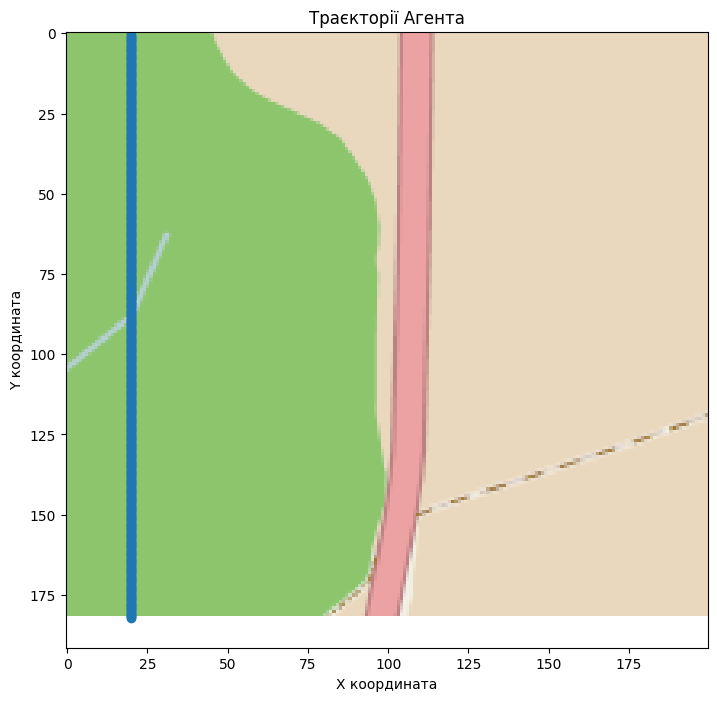

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Завантаження зображення середовища
environment_image = mpimg.imread('./img/output1small.png')
image_height, image_width, _ = environment_image.shape

scaled_positions = []
for episode in agent_positions:
    scaled_episode = [(x * image_width, y * image_height) for x, y in episode]
    scaled_positions.append(scaled_episode)


# Візуалізація
plt.figure(figsize=(10, 8))
plt.imshow(environment_image)

# Відображення кожної траєкторії
for episode in scaled_positions:
    x_positions, y_positions = zip(*episode)
    plt.plot(x_positions, y_positions, marker='o') # Ви можете налаштувати колір для кожного епізоду

plt.title('Траєкторії Агента')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.show()
